In [2]:
import MDAnalysis as mda
import MDAnalysis.analysis.rdf as rdf
import MDAnalysis.analysis.msd as msd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load trajectory in MDAnalysis
run = {'1.5': '10000', '1': '50000',
       '0.9': '150000', '0.8': '150000', 
       '0.7': '180000', '0.65': '350000', 
       '0.6': '1000000', '0.55': '3000000', 
       '0.5': '10000000', '0.475': '30000000', 
       '0.45': '100000000'}
prod_data = dict(zip(run.keys(), [None]*len(run.keys())))
for t in [1.5, 1, 0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.475]:
    prod_data[str(t)] = mda.Universe(f"../Data/equil/kalj_T{t}_n360_v300_{run[str(t)]}_1.lammpstrj", 
                                            f"../Data/prod/kalj_T{t}_n360_v300_prod_{run[str(t)]}_1.unwrap.dcd",
                                            topology_format="LAMMPSDUMP")

/ext3/miniconda3/lib/python3.9/site-packages/MDAnalysis/topology/LAMMPSParser.py:631: UserWarning: Guessed all Masses to 1.0
  warnings.warn('Guessed all Masses to 1.0')


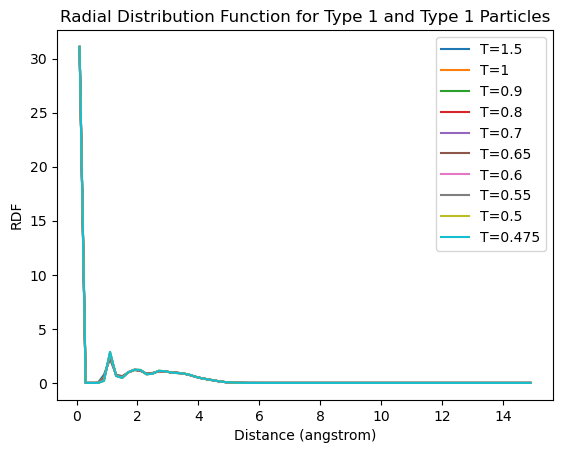

In [9]:
def calculate_rdf(prod_data):
    """Calculate radial distribution functions for given production data."""
    type1_atoms = prod_data.select_atoms("type 1")
    type2_atoms = prod_data.select_atoms("type 2")

    rdf_type1_type1 = rdf.InterRDF(type1_atoms, type1_atoms).run()
    rdf_type2_type2 = rdf.InterRDF(type2_atoms, type2_atoms).run()
    rdf_type1_type2 = rdf.InterRDF(type1_atoms, type2_atoms).run()

    return rdf_type1_type1, rdf_type2_type2, rdf_type1_type2

# Define temperatures
temperatures = [1.5, 1, 0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.475]

# Calculate RDFs for each temperature
rdf_results = {}
for temp in temperatures:
    rdf_results[temp] = calculate_rdf(prod_data[str(temp)])

# Plot the RDF for particle type 1 and 1
for temp, rdf_data in rdf_results.items():
    plt.plot(rdf_data[0].bins, rdf_data[0].rdf, label=f"T={temp}")

plt.xlabel('Distance (angstrom)')
plt.ylabel('RDF')
plt.legend()
plt.title('Radial Distribution Function for Type 1 and Type 1 Particles')
plt.savefig('../Figures/rdf_Type1-Type1.png')
plt.show()


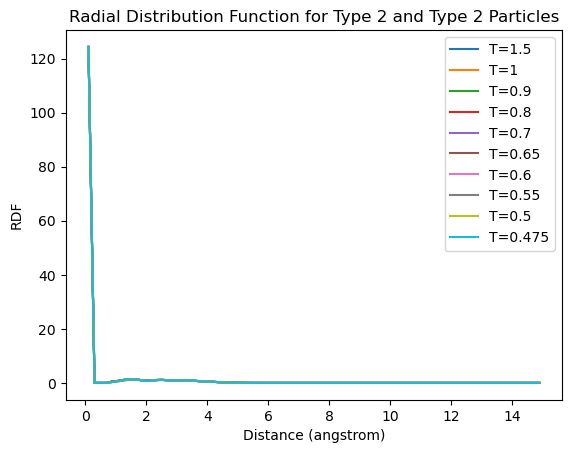

In [10]:
# Plot the RDF for particle type 2 and 2
for temp, rdf_data in rdf_results.items():
    plt.plot(rdf_data[1].bins, rdf_data[1].rdf, label=f"T={temp}")

plt.xlabel('Distance (angstrom)')
plt.ylabel('RDF')
plt.legend()
plt.title('Radial Distribution Function for Type 2 and Type 2 Particles')
plt.savefig('../Figures/rdf_Type2-Type2')
plt.show()

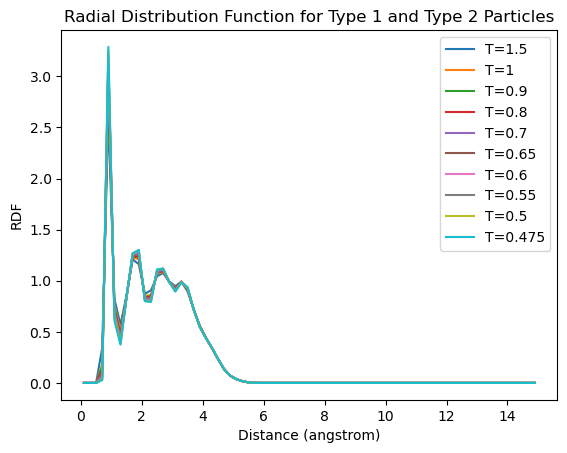

In [12]:
# Plot the RDF for particle type 1 and 2
for temp, rdf_data in rdf_results.items():
    plt.plot(rdf_data[2].bins, rdf_data[2].rdf, label=f"T={temp}")

plt.xlabel('Distance (angstrom)')
plt.ylabel('RDF')
plt.legend()
plt.title('Radial Distribution Function for Type 1 and Type 2 Particles')
plt.savefig('../Figures/rdf_Type1-Type2')
plt.show()

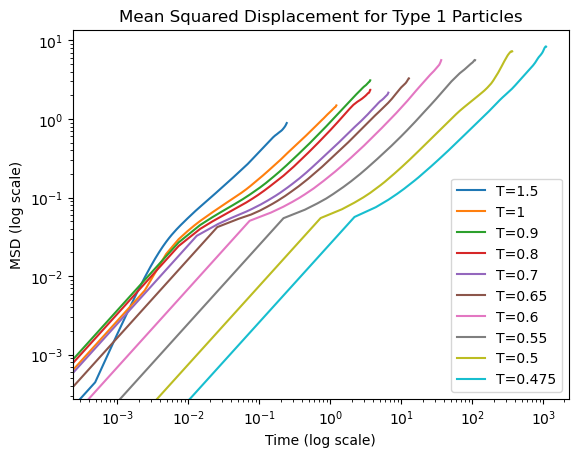

In [14]:
def calculate_msd(prod_data):
    """Calculate mean squared displacement for given production data."""
    type1_atoms = prod_data.select_atoms("type 1")
    msd_type1 = msd.EinsteinMSD(type1_atoms).run()
    return msd_type1

# Define temperatures
temperatures = [1.5, 1, 0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.475]

# Calculate MSDs for each temperature
msd_results = {}
for temp in temperatures:
    msd_results[temp] = calculate_msd(prod_data[str(temp)])

# Plot MSDs
for temp, msd_data in msd_results.items():
    # Calculate mean squared displacement by particle
    mean_msd = msd_data.results['msds_by_particle'].mean(axis=1)

    # Log-log plot
    plt.loglog(msd_data.times, mean_msd, label=f'T={temp}')

plt.xlabel('Time (log scale)')
plt.ylabel('MSD (log scale)')
plt.title('Mean Squared Displacement for Type 1 Particles')
plt.legend()
plt.savefig('../Figures/3D_MSD_Type1.png')
plt.show()

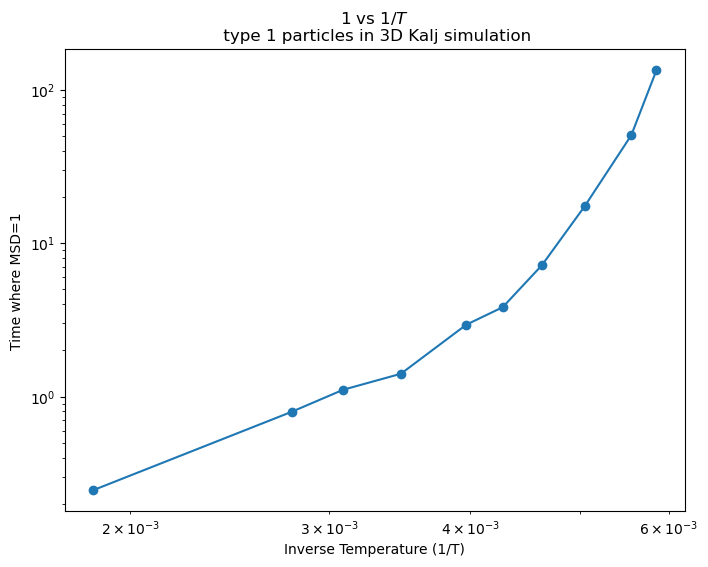

In [18]:
def find_time_when_msd_reaches_threshold(msd_obj, threshold=1):
    """Find the time at which the mean squared displacement reaches a given threshold."""
    msd_obj.run()
    mean_msd = msd_obj.results['msds_by_particle'].mean(axis=1)
    
    # Find index where the MSD first exceeds the threshold
    index = np.argmax(mean_msd >= threshold) if np.any(mean_msd >= threshold) else -1
    return msd_obj.times[index] if index != -1 else msd_obj.times[-1]

msd_dict = {}
for t in [1.5, 1, 0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.475]:
    msd_dict[t] = cal_msd(prod_data[str(t)])

# Define temperatures and initialize dictionary
temperatures = []
times_msd_1 = {}

for temp_str, msd_obj in msd_dict.items():
    # Extract numerical value of temperature from the string and convert to inverse temperature
    temp = float(temp_str) * 360
    temperatures.append(1 / temp)
    
    # Find the time where MSD first reaches 1 and store it
    time = find_time_when_msd_reaches_threshold(msd_obj)
    times_msd_1[temp_str] = time

# Convert lists to numpy arrays for plotting
temperatures_np = np.array(temperatures)
times_np = np.array(list(times_msd_1.values()))

# Create the log-log plot
plt.figure(figsize=(8, 6))
plt.loglog(temperatures_np, times_np, 'o-')  # 'o-' creates a line plot with circle markers

plt.xlabel('Inverse Temperature (1/T)')
plt.ylabel('Time where MSD=1')
plt.title('1 vs $1/T$\n type 1 particles in 3D Kalj simulation')
plt.savefig('../Figures/3D_diffusion_time_vs_temp.png')
plt.show()
